In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import torch.onnx
import onnx

import scipy.io as sio

import os
import shutil

In [2]:
#data = sio.loadmat('Stanford_cars_dataset/cars_annos.mat')
#class_names = data['class_names'][0]
#annotations = data['annotations'][0]

In [3]:
# Путь к основной папке датасета
#dataset_folder = 'C:/Users/dmitr/DataspellProjects/CarResNet152/Stanford_cars_dataset'

# Путь к папке с изображениями для обучения
#train_folder = 'C:/Users/dmitr/DataspellProjects/CarResNet152/Stanford_cars_dataset/cars_train/cars_train'

# Путь к папке с изображениями для тестирования
#test_folder = 'C:/Users/dmitr/DataspellProjects/CarResNet152/Stanford_cars_dataset/cars_test/cars_test'

# Создание папок для классов
#for class_name in class_names:
    #os.makedirs(os.path.join(dataset_folder, 'train', str(class_name)))
    #os.makedirs(os.path.join(dataset_folder, 'test', str(class_name)))
    #os.makedirs(os.path.join(dataset_folder, 'val', str(class_name)))

# Перемещение изображений в соответствующие папки
#for annotation in annotations:
    #file_name = (annotation[0][0]).split('/')[-1]
    #class_index = annotation[5][0][0]
    #class_name = class_names[class_index - 1]

    # Определение пути к исходному и целевому файлу
    #source_path = os.path.join(train_folder if annotation[6][0][0] == 1 else test_folder) + '/' + file_name[1:]
    #target_path = os.path.join(dataset_folder, 'train' if annotation[6][0][0] == 1 else 'test' if annotation[6][0][0] == 0 else 'val', str(class_name), file_name[1:])

    # Перемещение файла
    #shutil.move(source_path, target_path)

In [3]:
train_path = 'Stanford_cars_dataset/car_data/car_data/train'
test_path = 'Stanford_cars_dataset/car_data/car_data/test'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Определение аугментаций
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Случайное отражение по горизонтали
    transforms.RandomRotation(10),  # Случайный поворот на 10 градусов
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Изменение цветов
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание датасетов для тренировочных и тестовых данных
train_data = ImageFolder(train_path, transform=train_transform)
test_data = ImageFolder(test_path, transform=transform)

In [4]:
# Инициализация модели
model = models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
num_classes = 197
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Создание загрузчика данных
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(torch.version.__version__)
print(torch.backends.cudnn.version())

#input_node_name = list(model.state_dict().keys())[0]  # имя первого узла модели
#output_node_name = list(model.state_dict().keys())[-1]  # имя последнего узла модели

#print(input_node_name)
#print(output_node_name)
#output_node_name
#model.named_parameters()
#model.state_dict().keys()

2.1.1+cu121
8801


In [58]:
num_epochs = 40
best_accuracy = 0.0  # Инициализация переменной для хранения лучшей точности

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Сохранение модели, если текущая точность на тестовой выборке лучше, чем лучшая за все время обучения
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Прекращение обучения, если достигнута целевая точность
    if test_acc >= 0.8:
        print("Целевая точность достигнута. Прекращение обучения.")
        break

Epoch 1/40: Train Loss: 0.3930, Train Acc: 0.8797, Test Loss: 0.9530, Test Acc: 0.7431
Epoch 2/40: Train Loss: 0.3152, Train Acc: 0.9022, Test Loss: 0.9243, Test Acc: 0.7544
Epoch 3/40: Train Loss: 0.2562, Train Acc: 0.9198, Test Loss: 0.9084, Test Acc: 0.7607
Epoch 4/40: Train Loss: 0.2268, Train Acc: 0.9310, Test Loss: 0.9759, Test Acc: 0.7463
Epoch 5/40: Train Loss: 0.2008, Train Acc: 0.9392, Test Loss: 0.9231, Test Acc: 0.7567
Epoch 6/40: Train Loss: 0.1620, Train Acc: 0.9499, Test Loss: 0.9239, Test Acc: 0.7598
Epoch 7/40: Train Loss: 0.1636, Train Acc: 0.9518, Test Loss: 0.9353, Test Acc: 0.7652
Epoch 8/40: Train Loss: 0.1657, Train Acc: 0.9497, Test Loss: 0.9775, Test Acc: 0.7474
Epoch 9/40: Train Loss: 0.1299, Train Acc: 0.9625, Test Loss: 1.0075, Test Acc: 0.7555
Epoch 10/40: Train Loss: 0.1231, Train Acc: 0.9636, Test Loss: 1.0165, Test Acc: 0.7500
Epoch 11/40: Train Loss: 0.1081, Train Acc: 0.9718, Test Loss: 0.9470, Test Acc: 0.7608
Epoch 12/40: Train Loss: 0.1020, Train Ac

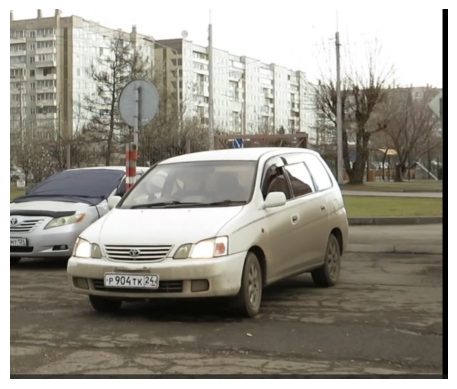

Предсказанный класс: Toyota Gaia 2000
Точность: 0.9509482979774475


In [10]:
from PIL import Image
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_model.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Загрузка и предобработка изображения
image_path = 'C:/Users/dmitr/DataspellProjects/CarResNet152/mycar.jpg'
image = Image.open(image_path)


# Отображение изображения
plt.imshow(image)
plt.axis('off')  # Убираем оси координат
plt.show()

image.convert('RGB')
image = transform(image)
image = image.unsqueeze(0)  # Добавление размерности пакета

image = image.to(device)

# Передача изображения через модель
model.eval()
with torch.no_grad():
    outputs = model(image)

# Получение предсказания и точности
_, predicted = torch.max(outputs, 1)
probability = torch.nn.functional.softmax(outputs, dim=1)[0][predicted.item()].item()
predicted_class = train_data.classes[predicted.item()]

print("Предсказанный класс:", predicted_class)
print("Точность:", probability)

In [7]:
train_data.classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)
torch_out = model(x)

# Input to the model
torch.onnx.export(model,
                  x,
                  "C:/temp/carresnet152.onnx",
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
#optimization
                  #input_names = ['conv1.weight'],   # the model's input names
                  #output_names = ['fc.bias'], # the model's output names
                  #input_names= ['input'],
                  #output_names= ['output']
                )


In [17]:
onnx_model = onnx.load("C:/temp/carresnet152.onnx")
onnx.checker.check_model(onnx_model)

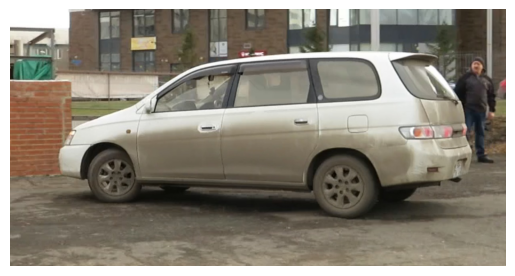

Класс 0: -38.60453796386719
Класс 1: -30.563674926757812
Класс 2: -31.171356201171875
Класс 3: -22.803369522094727
Класс 4: -23.681352615356445
Класс 5: -28.96632194519043
Класс 6: -34.62717056274414
Класс 7: -42.77443313598633
Класс 8: -33.434078216552734
Класс 9: -33.427284240722656
Класс 10: -38.53815841674805
Класс 11: -35.11751174926758
Класс 12: -16.41036605834961
Класс 13: -28.176227569580078
Класс 14: -39.26141357421875
Класс 15: -43.75178146362305
Класс 16: -29.006868362426758
Класс 17: -26.854190826416016
Класс 18: -31.082447052001953
Класс 19: -39.13703155517578
Класс 20: -20.481060028076172
Класс 21: -43.34305953979492
Класс 22: -41.875038146972656
Класс 23: -38.06249237060547
Класс 24: -38.0515022277832
Класс 25: -38.67427062988281
Класс 26: -22.484603881835938
Класс 27: -24.052997589111328
Класс 28: -12.57986068725586
Класс 29: -27.517789840698242
Класс 30: -24.53258514404297
Класс 31: -33.39183807373047
Класс 32: -21.55054473876953
Класс 33: -42.72511672973633
Класс 34: 

In [30]:
import onnxruntime

# Загрузка и предобработка изображения
image_path = 'C:/Users/dmitr/DataspellProjects/CarResNet152/mycar2.jpg'
image = Image.open(image_path)

# Отображение изображения
plt.imshow(image)
plt.axis('off')  # Убираем оси координат
plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image.convert('RGB')
image = transform(image)

image_PIL = transforms.ToPILImage()(image)
image_PIL.save("C:/temp/tested.jpg")

image = image.unsqueeze(0)  # Добавление размерности пакета

ort_session = onnxruntime.InferenceSession("C:/temp/carresnet152.onnx", providers=["CPUExecutionProvider"])

ort_inputs = {ort_session.get_inputs()[0].name: image.numpy()}

ort_outs = ort_session.run(None, ort_inputs)

# Получение предсказания и точности
_, predicted = torch.max(torch.from_numpy(ort_outs[0]), 1)
prob = torch.nn.functional.softmax(torch.from_numpy(ort_outs[0]), dim=1)[0][predicted.item()].item()
predicted_class = train_data.classes[predicted.item()]

output_name = ort_session.get_outputs()[0].name
output_data = ort_outs[0]
probabilities = output_data[0]


# Вывод вероятностей распознавания
for i, probability in enumerate(probabilities):
    print(f"Класс {i}: {probability}")
    
print (prob)
